# **Problem 2: Getting Familiar with the Wiener filtering**

In [33]:
import numpy as np
import cv2
from scipy.ndimage import convolve
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, ifft2
from scipy.signal import find_peaks

# A.

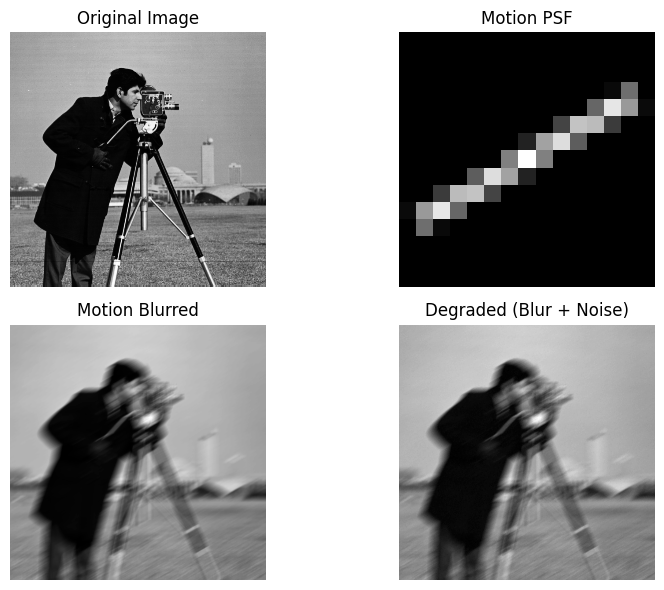

In [2]:
# Create motion blur PSF with length L and angle theta
def generate_motion_blur_psf(L, theta_deg, size=None):
    if size is None:
        size = L + 2  
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    start = center - L // 2
    end = start + L

    # Create linear motion blur kernel
    kernel[center, start:end] = np.ones(L, dtype=np.float32) / L
    rotated_kernel = rotate(kernel, angle=theta_deg, reshape=False, order=1, mode='nearest')
    rotated_kernel /= rotated_kernel.sum()

    start = (size - L) // 2
    end = start + L
    return rotated_kernel[start:end, start:end]

# Apply zero-mean Gaussian noise with sigma
def add_gaussian_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255)

image = cv2.imread('cameraman.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("File 'cameraman.png' not found!")

# motion blur parameters
L = 15
theta = 30  
sigma_noise = 1 

# Generate point spread function (PSF) 
psf = generate_motion_blur_psf(L, theta)

# Apply motion blur
blurred = convolve(image.astype(np.float32), psf, mode='reflect')

# Add Gaussian noise to blurred image
degraded = add_gaussian_noise(blurred, sigma=sigma_noise)

plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Motion PSF")
plt.imshow(psf, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Motion Blurred")
plt.imshow(blurred.astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Degraded (Blur + Noise)")
plt.imshow(degraded.astype(np.uint8), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Part B.

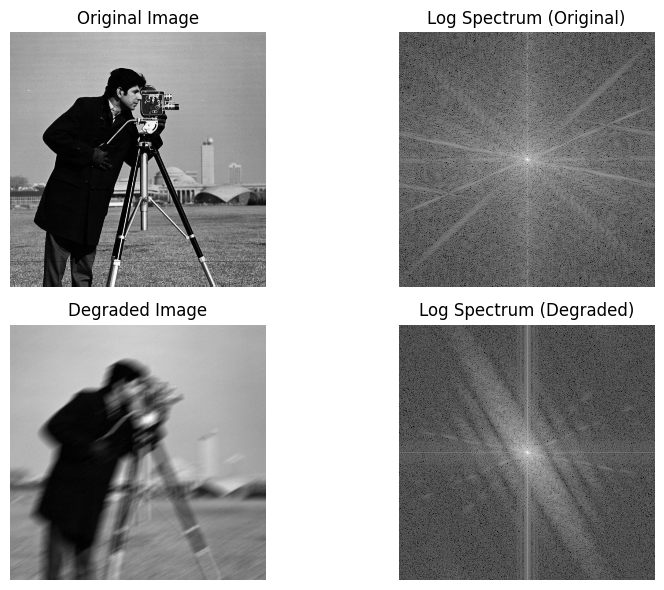

In [3]:
# Compute centered log magnitude spectrum of the image
def compute_log_magnitude_spectrum(image):
    dft = fft2(image)
    dft_shifted = fftshift(dft)
    magnitude_spectrum = np.log(np.abs(dft_shifted) + 1e-3)
    return magnitude_spectrum

image = image.astype(np.float32)
degraded = degraded.astype(np.float32)

# Compute spectra
spectrum_original = compute_log_magnitude_spectrum(image)
spectrum_degraded = compute_log_magnitude_spectrum(degraded)

plt.figure(figsize=(9, 6))
# Original image and its spectrum
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Log Spectrum (Original)")
plt.imshow(spectrum_original, cmap='gray')
plt.axis('off')

# Degraded image and its spectrum
plt.subplot(2, 2, 3)
plt.title("Degraded Image")
plt.imshow(np.clip(degraded, 0, 255).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Log Spectrum (Degraded)")
plt.imshow(spectrum_degraded, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Part C.

 Distance between dark lines (d): 16.62 pixels
 Delta u (frequency spacing): 0.0649
 Estimated motion length (L): 15.40 pixels


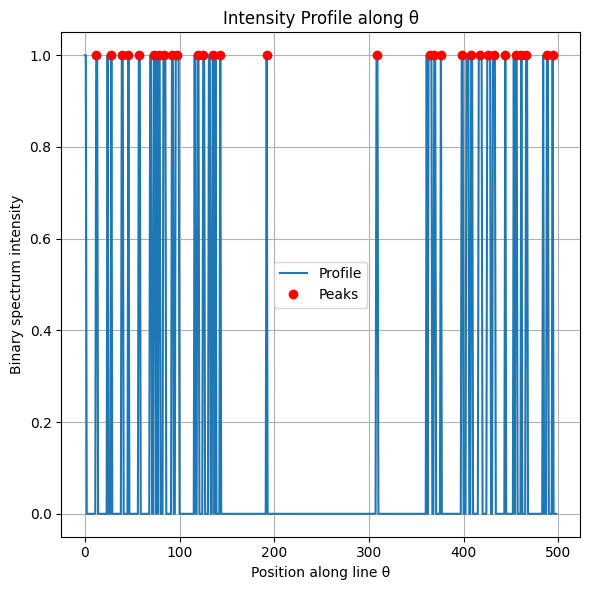

In [ ]:
degraded = degraded.astype(np.float32)
spectrum_degraded = np.log(np.abs(fftshift(fft2(degraded)) + 1e-3))

# Threshold to binarize spectrum
threshold = np.percentile(spectrum_degraded, 20) 
binary_spectrum = spectrum_degraded < threshold

# Set parameters for profile extraction 
N = degraded.shape[0]
center = N // 2
length = int(N / 2)
angle_deg  = 29.8
angle_rad  = np.deg2rad(angle_deg )
x = np.linspace(-length, length, 500)  
y = x * np.tan(angle_rad )

x_coords = (center + x).astype(int)
y_coords = (center + y).astype(int)
valid = (x_coords >= 0) & (x_coords < N) & (y_coords >= 0) & (y_coords < N)
x_coords = x_coords[valid]
y_coords = y_coords[valid]

profile = binary_spectrum[y_coords, x_coords]

# Detect peaks to estimate spacing between dark lines
peaks, _ = find_peaks(profile, distance=5)
if len(peaks) > 1:
    d = np.mean(np.diff(peaks))
    delta_u = d / N
    L = 1 / delta_u
    print(f" Distance between dark lines (d): {d:.2f} pixels")
    print(f" Delta u (frequency spacing): {delta_u:.4f}")
    print(f" Estimated motion length (L): {L:.2f} pixels")


plt.figure(figsize=(6, 6))
plt.plot(profile, label="Profile")
plt.plot(peaks, profile[peaks], 'ro', label="Peaks")
plt.title(f"Intensity Profile along θ")
plt.xlabel("Position along line θ")
plt.ylabel("Binary spectrum intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Part D.

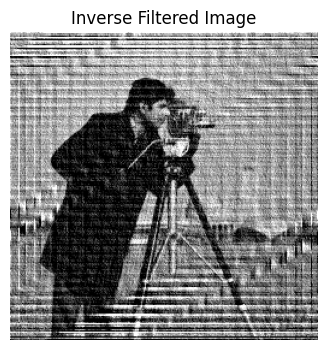

Estimated K: 0.002594917


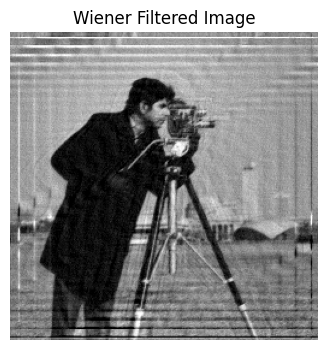

In [42]:
# Manual blur length and angle estimate
L_manual = 15   
theta_manual = 29.8  

# Generate and pad PSF to match image size
psf_manual = generate_motion_blur_psf(L_manual, theta_manual)
psf_padded = np.zeros_like(image, dtype=np.float32)
psf_size = psf_manual.shape
psf_padded[:psf_size[0], :psf_size[1]] = psf_manual

psf_padded = np.roll(psf_padded, -psf_size[0] // 2, axis=0)
psf_padded = np.roll(psf_padded, -psf_size[1] // 2, axis=1)

# Compute DFTs of degraded image and PSF
G = fft2(degraded.astype(np.float32))
H = fft2(psf_padded.astype(np.float32))

# Simple inverse filter
eps = 3e-2  
H_abs = np.abs(H)
H_safe = np.where(H_abs < eps, eps, H)  
F_hat_inv = G / H_safe
f_inv = np.real(ifft2(F_hat_inv))

# Display inverse filtered result
plt.figure(figsize=(4, 4))
plt.title("Inverse Filtered Image")
plt.imshow(np.clip(f_inv, 0, 255).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

# Estimate noise and signal variances
noise_patch = degraded[:30, :30].astype(np.float32) 
sigma_eta2 = np.var(noise_patch)
sigma_f2 = np.var(degraded.astype(np.float32))  
K = sigma_eta2 / sigma_f2

# Clamp K to stable range if out of bounds
if K < 1e-3 or K > 1e-2:
    K = 5e-3  
    print("K adjusted to 5e-3")
print("Estimated K:", K)

# Wiener filter
H_conj = np.conj(H)
denominator = np.abs(H) ** 2 + K
F_hat_wiener = (H_conj / denominator) * G
f_wiener = np.real(ifft2(F_hat_wiener))

# Display Wiener filtered result
plt.figure(figsize=(4, 4))
plt.title("Wiener Filtered Image")
plt.imshow(np.clip(f_wiener, 0, 255).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

# Part E.

'Explanation of this part in the report.'